In [238]:
import Loader
import glob
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, make_scorer, roc_auc_score
from sklearn import feature_selection
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits, make_friedman1
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, StratifiedKFold
from sklearn import svm
from scipy import interp, stats
import itertools
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import scikitplot as skplt

In [64]:
m = 115
step = 1
upper = 21
    
cluster_sizes, outcomes, positives, cluster_features_names, codes = Loader.load_cluster_size_histograms_singular(m=m, upper=upper, scaled=True)

In [65]:
raw_images, outcomes, t, d, cluster_range = Loader.get_heatmaps(m=115, d=50, t=886, take_lymphocyte_ratio=True)

num_bins = 20

heatmap_features_names = ["heatmap heat " + str(i+1) + "/" + str(num_bins) for i in range(num_bins)]
heatmap_features_names[0] = heatmap_features_names[0] + " (coldest)"
heatmap_features_names[-1] = heatmap_features_names[-1] + " (hottest)"
heatmap_features_names = np.asarray(heatmap_features_names)

heatmaps = []

for i, hmap in enumerate(raw_images):
    histogram, bins = np.histogram((hmap).ravel(), bins=num_bins, range=(0.0, 1.0), density=True)
    heatmaps.append(histogram.reshape(histogram.shape[0], 1))

heatmaps = np.asarray(heatmaps).reshape(115, 20)

In [98]:
feature_names = np.append(cluster_features_names, heatmap_features_names)
feature_names = np.append(feature_names, np.array(["class"]))
print(feature_names.shape)

print(cluster_sizes_normed.shape)
print(heatmaps_normed.shape)
print(feature_names.shape)

X = np.append(cluster_sizes_normed, heatmaps_normed, axis=1)
y = outcomes.reshape(m, )
# y = outcomes.reshape(m, 1)

(42,)
(115, 21)
(115, 20)
(42,)


In [99]:
print(X.shape)

(115, 41)


In [100]:
print(y.shape)

(115,)


In [ ]:
# Load the data. Then, split into X_train, y_train, X_test, and y_test.

# Select a model (from GridSearchCV or some list of models)

# For each fold of stratified cross val of (X_train, y_train):
# Let X_fold, y_fold be the X and y of the fold
# Apply SMOTE (and recall that SMOTE can also be tuned). 
# Normalise data
# Apply feature selection or dimensionality reduction (e.g. RFE, PCA) if applicable
# Fit the data with the model
# Predict X_fold, y_fold with the fitted model. Get the raw probabilities back

# When done with experimenting and checking final result, test on X_test, y_test with same procedure but do not
# use SMOTE. SMOTE is only used to create synthetic examples that assist training. 

In [80]:
### NAIVE BAYES ###

# Try class priors based on the ratio of positives to negatives in our dataset. We have 15 fatal cases,
# 100 non-fatal. 15/115 is roughly 13%.
class_priors = [0.13, 0.87]

model = GaussianNB(class_priors)

clf = Pipeline(steps=[("scaling", StandardScaler), ("estimator", model)])
print(type(clf))

sampler = SMOTE(random_state=0)
X_smote, y_smote = sampler.fit_sample(X, y)

# If test dataset is too small, likely to have very high variance in results. We'll use 10-fold cross-validation
# to maximise our efficiency of learning from the training data. We'll stratify to reflect the actual distribution
# of the classes (which is to say highly imbalanced!).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

# Set the random_state so that our results are reusable.
cross_val = StratifiedKFold(n_splits=10, random_state=0)

for train, test in cross_val.split(X_train, y_train):
    local_X_train, local_y_train = X_train[train], y_train[train]
    local_X_test, local_y_test = X_train[test], y_train[test]
    local_X_train_smote, local_y_train_smote = sampler.fit_sample(local_X_train, local_y_train)
    print(type(clf))
    clf.fit(local_X_train_smote, local_y_train_smote)
    clf.score(local_X_test, local_y_test, make_scorer())
#     print(local_X_train_smote.shape)

<class 'sklearn.pipeline.Pipeline'>
<class 'sklearn.pipeline.Pipeline'>


AttributeError: 'numpy.ndarray' object has no attribute 'fit'

Original dataset shape Counter({0: 100, 1: 15})


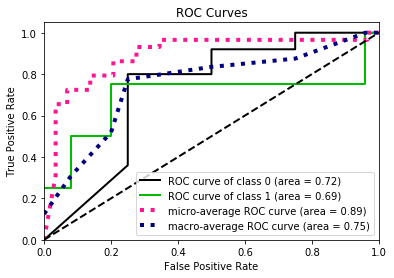

In [237]:
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 

print('Original dataset shape {}'.format(Counter(y)))

smt = SMOTE(random_state=0)
# X_smote, y_smote = smt.fit_sample(X, y)

scaler = StandardScaler()
nb = GaussianNB()
pipeline = Pipeline([('smt', smt), ('norm', scaler), ('nb', nb)])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
pipeline.fit(X_train, y_train) 

y_hat = pipeline.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_hat)